In [1]:
# Initialize
import findspark
findspark.init('/home/user/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Iteration4clas').getOrCreate()

# load Data
df = spark.read.csv('source/final-data.csv',header=True,inferSchema=True)
df=df.select('RA','SN','TS','FG','AQI Quality')

### classification
    decision tree classifier

In [2]:
# Import VectorAssembler and Vectors
from pyspark.ml.feature import (VectorAssembler,StringIndexer)

In [3]:
# create a string indexer which converts every string into a number.
# A number will be assigned to every category in the column.
aqi_indexer = StringIndexer(inputCol='AQI Quality',outputCol='label')



In [4]:
# use vector assembler to turn all of these columns into one column (named features).
assemblerMlr = VectorAssembler(inputCols=['RA','SN','TS','FG'], outputCol="features")

In [5]:
from pyspark.ml import Pipeline

# Then go through our steps. It's essentially sequential to the above.
pipeline = Pipeline(stages=[aqi_indexer,assemblerMlr])

# Now that we've got a number of steps, let's apply it to the DataFrame.
pipeline_model = pipeline.fit(df)

# Incorporate results into a new DataFrame.
pipe_df = pipeline_model.transform(df)
pipe_df.show()


+---+---+---+---+-------------------+-----+-----------------+
| RA| SN| TS| FG|        AQI Quality|label|         features|
+---+---+---+---+-------------------+-----+-----------------+
|  0|  0|  0|  0|               Good|  0.0|        (4,[],[])|
|  0|  0|  0|  0|               Good|  0.0|        (4,[],[])|
|  0|  0|  0|  0|Moderately Polluted|  3.0|        (4,[],[])|
|  0|  0|  0|  0|   Heavily Polluted|  4.0|        (4,[],[])|
|  0|  0|  0|  0|Moderately Polluted|  3.0|        (4,[],[])|
|  0|  0|  0|  0|               Good|  0.0|        (4,[],[])|
|  0|  0|  0|  0|               Good|  0.0|        (4,[],[])|
|  0|  0|  0|  0|Moderately Polluted|  3.0|        (4,[],[])|
|  0|  0|  0|  0|               Good|  0.0|        (4,[],[])|
|  0|  0|  0|  0|Moderately Polluted|  3.0|        (4,[],[])|
|  0|  0|  0|  0|               Good|  0.0|        (4,[],[])|
|  0|  0|  0|  0|Moderately Polluted|  3.0|        (4,[],[])|
|  0|  0|  0|  0|   Heavily Polluted|  4.0|        (4,[],[])|
|  0|  1

In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="AQI Quality", outputCol="indexedLabel").fit(pipe_df)
# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(pipe_df)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = pipe_df.randomSplit([0.7, 0.3])

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))

treeModel = model.stages[2]
# summary only
print(treeModel)

+----------+------------+---------+
|prediction|indexedLabel| features|
+----------+------------+---------+
|       0.0|         1.0|(4,[],[])|
|       0.0|         1.0|(4,[],[])|
|       0.0|         1.0|(4,[],[])|
|       0.0|         1.0|(4,[],[])|
|       0.0|         1.0|(4,[],[])|
+----------+------------+---------+
only showing top 5 rows

Test Error = 0.624277 
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_434ba343ecbd0ca6d8ec) of depth 4 with 21 nodes


#### patterns for Severly polluted AQI Quality

In [7]:
pipe1=pipe_df.filter('label=0')
pipe1.select('RA','SN','TS','FG').describe().show()

+-------+-------------------+--------------------+-------------------+--------------------+
|summary|                 RA|                  SN|                 TS|                  FG|
+-------+-------------------+--------------------+-------------------+--------------------+
|  count|                405|                 405|                405|                 405|
|   mean|0.30864197530864196|0.024691358024691357|0.09876543209876543|0.024691358024691357|
| stddev| 0.4625043566463787| 0.15537471808241782| 0.2987158270610311| 0.15537471808241785|
|    min|                  0|                   0|                  0|                   0|
|    max|                  1|                   1|                  1|                   1|
+-------+-------------------+--------------------+-------------------+--------------------+



In [8]:
pipe1=pipe_df.filter('label=1')
pipe1.select('RA','SN','TS','FG').describe().show()

+-------+-------------------+-------------------+--------------------+--------------------+
|summary|                 RA|                 SN|                  TS|                  FG|
+-------+-------------------+-------------------+--------------------+--------------------+
|  count|                266|                266|                 266|                 266|
|   mean|0.21428571428571427|0.02631578947368421|0.041353383458646614|0.003759398496240...|
| stddev| 0.4110993741393795|0.16037443773261875| 0.19948152401280497| 0.06131393394849658|
|    min|                  0|                  0|                   0|                   0|
|    max|                  1|                  1|                   1|                   1|
+-------+-------------------+-------------------+--------------------+--------------------+



In [9]:
pipe1=pipe_df.filter('label=2')
pipe1.select('RA','SN','TS','FG').describe().show()

+-------+-------------------+-------------------+-------------------+-------------------+
|summary|                 RA|                 SN|                 TS|                 FG|
+-------+-------------------+-------------------+-------------------+-------------------+
|  count|                221|                221|                221|                221|
|   mean|0.25339366515837103|0.02262443438914027|0.09954751131221719|0.04072398190045249|
| stddev| 0.4359417952763628| 0.1490405348776313| 0.3000754053046972|0.19809873758140187|
|    min|                  0|                  0|                  0|                  0|
|    max|                  1|                  1|                  1|                  1|
+-------+-------------------+-------------------+-------------------+-------------------+



In [10]:
pipe1=pipe_df.filter('label=3')
pipe1.select('RA','SN','TS','FG').describe().show()

+-------+-------------------+-------------------+-------------------+-------------------+
|summary|                 RA|                 SN|                 TS|                 FG|
+-------+-------------------+-------------------+-------------------+-------------------+
|  count|                103|                103|                103|                103|
|   mean|0.36893203883495146|0.06796116504854369| 0.1262135922330097|0.10679611650485436|
| stddev| 0.4848749841329817|0.25290996314390796|0.33371385096103495| 0.3103641554760769|
|    min|                  0|                  0|                  0|                  0|
|    max|                  1|                  1|                  1|                  1|
+-------+-------------------+-------------------+-------------------+-------------------+



In [11]:
pipe1=pipe_df.filter('label=4')
pipe1.select('RA','SN','TS','FG').describe().show()

+-------+-------------------+-------------------+--------------------+-------------------+
|summary|                 RA|                 SN|                  TS|                 FG|
+-------+-------------------+-------------------+--------------------+-------------------+
|  count|                 68|                 68|                  68|                 68|
|   mean|0.22058823529411764|0.08823529411764706|0.014705882352941176| 0.4264705882352941|
| stddev| 0.4177261916648386| 0.2857456398198083|  0.1212678125181665|0.49824097959612124|
|    min|                  0|                  0|                   0|                  0|
|    max|                  1|                  1|                   1|                  1|
+-------+-------------------+-------------------+--------------------+-------------------+



In [12]:
pipe1=pipe_df.filter('label=5')
pipe1.select('RA','SN','TS','FG').describe().show()

+-------+---+-------------------+---+-------------------+
|summary| RA|                 SN| TS|                 FG|
+-------+---+-------------------+---+-------------------+
|  count| 27|                 27| 27|                 27|
|   mean|0.0|0.18518518518518517|0.0| 0.7037037037037037|
| stddev|0.0| 0.3958473906635695|0.0|0.46532162696807516|
|    min|  0|                  0|  0|                  0|
|    max|  0|                  1|  0|                  1|
+-------+---+-------------------+---+-------------------+



In [13]:
#  visualize

In [38]:
#  count days of factors of different AQI:
g1=df.filter('RA=1').groupBy('AQI Quality').count()
g2=df.filter('SN=1').groupBy('AQI Quality').count()
g3=df.filter('TS=1').groupBy('AQI Quality').count()
g4=df.filter('FG=1').groupBy('AQI Quality').count()

# print them out
g1.head(6)

[Row(AQI Quality='Excellent', count=57),
 Row(AQI Quality='Lightly Polluted', count=56),
 Row(AQI Quality='Heavily Polluted', count=15),
 Row(AQI Quality='Good', count=125),
 Row(AQI Quality='Moderately Polluted', count=38)]

In [39]:
g2.head(6)

[Row(AQI Quality='Excellent', count=7),
 Row(AQI Quality='Lightly Polluted', count=5),
 Row(AQI Quality='Heavily Polluted', count=6),
 Row(AQI Quality='Good', count=10),
 Row(AQI Quality='Severely Polluted', count=5),
 Row(AQI Quality='Moderately Polluted', count=7)]

In [40]:
g3.head(6)

[Row(AQI Quality='Excellent', count=11),
 Row(AQI Quality='Lightly Polluted', count=22),
 Row(AQI Quality='Heavily Polluted', count=1),
 Row(AQI Quality='Good', count=40),
 Row(AQI Quality='Moderately Polluted', count=13)]

In [41]:
g4.head(6)

[Row(AQI Quality='Excellent', count=1),
 Row(AQI Quality='Lightly Polluted', count=9),
 Row(AQI Quality='Heavily Polluted', count=29),
 Row(AQI Quality='Good', count=10),
 Row(AQI Quality='Severely Polluted', count=19),
 Row(AQI Quality='Moderately Polluted', count=11)]

In [4]:
# get packages for visualization 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
mdata = {'mtype': ['RA', 'SN', 'TS', 'FG'],
        'Excellent': [57, 7, 11, 1],
        'Good': [125, 10, 40, 10],
        'Light': [56, 5, 22, 9],
        'Moderate': [38, 7, 13, 11],
        'Heavy': [15, 6, 1, 29],
        'Severe': [0, 5, 0, 19]}
dfm = pd.DataFrame(mdata, columns = ['mtype', 'Excellent', 'Good', 'Light', 'Moderate', 'Heavy', 'Severe'])
dfm

,mtype,Excellent,Good,Light,Moderate,Heavy,Severe
0,RA,57,125,56,38,15,0
1,SN,7,10,5,7,6,5
2,TS,11,40,22,13,1,0
3,FG,1,10,9,11,29,19


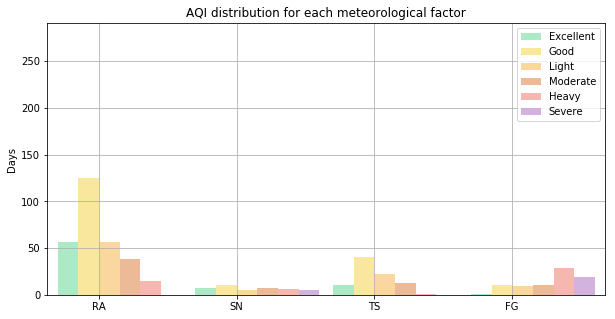

In [8]:
# Setting the positions and width for the bars
pos = list(range(len(dfm['Excellent']))) 
width = 0.15 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with Excellent data,
# in position pos,
plt.bar(pos, 
        dfm['Excellent'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#58D68D', 
        label=dfm['mtype'][0]) 

# Create a bar with Good data,
# in position pos,
plt.bar([p + width for p in pos], 
        dfm['Good'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F4D03F', 
        label=dfm['mtype'][0]) 

# Create a bar with Light data,
# in position pos,
plt.bar([p + width*2 for p in pos], 
        dfm['Light'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F5B041',
        label=dfm['mtype'][1]) 


# Create a bar with Moderate data,
# in position pos,
plt.bar([p + width*3 for p in pos], 
        dfm['Moderate'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#DC7633', 
        label=dfm['mtype'][1]) 

# Create a bar with Heavy data,
# in position pos,
plt.bar([p + width*4 for p in pos], 
        dfm['Heavy'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#EC7063', 
        # with label the first value in first_name
        label=dfm['mtype'][2]) 


# Create a bar with Severe data,
# in position pos,
plt.bar([p + width*5 for p in pos], 
        dfm['Severe'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#A569BD', 
        # with label the first value in first_name
        label=dfm['mtype'][2]) 


# Set the y axis label
ax.set_ylabel('Days')

# Set the chart's title
ax.set_title('AQI distribution for each meteorological factor')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(dfm['mtype'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*6)
plt.ylim([0, max(dfm['Excellent']+ dfm['Good']+ dfm['Light']+ dfm['Moderate']+ dfm['Heavy']+ dfm['Severe'])] )

# Adding the legend and showing the plot
plt.legend(['Excellent', 'Good', 'Light','Moderate','Heavy','Severe'], loc='upper right')
plt.grid()
plt.show()